<a href="https://colab.research.google.com/github/Veciam-CF/DSPS_ZGao/blob/main/HW8/higgsbosonSearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import pylab as pl
import os
import json
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix
from pprint import pprint
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [6]:
#mount your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Remember tasks are not completed if you do not comment on the results and include captions

# Task 1 : data ingestion

- Download the Higgs boson data from Kaggle (programmatically within the notebook)

see how I did it in the Titanic Trees notebook https://github.com/fedhere/DSPS_FBianco/blob/main/CodeDemos/titanictree.ipynb

find the correct API link here https://www.kaggle.com/c/higgs-boson/data. The command is `!kaggle competitions download......` (you may need to agree to the terms of condition of the higgs boson challenge on the kaggle webpage)


In [7]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [8]:
envs = json.load(open("kaggle.json", "r")) # added kaggle/ for me -Ally
os.environ["KAGGLE_USERNAME"] = envs['username']
os.environ["KAGGLE_KEY"] = envs['key']

In [9]:
cd dsps

/content/gdrive/MyDrive/dsps


In [10]:
!mkdir higgsboson

mkdir: cannot create directory ‘higgsboson’: File exists


In [11]:
cd higgsboson

/content/gdrive/MyDrive/dsps/higgsboson


In [12]:
!kaggle competitions download -c higgs-boson

higgs-boson.zip: Skipping, found more recently modified local copy (use --force to force download)


In [13]:
ls

HiggsBosonCompetition_AMSMetric_rev1.py  random_submission.zip  training.csv
higgs-boson.zip                          test.zip               training.zip


In [14]:
# already done remember to uncomment before submitting
!unzip higgs-boson.zip
!unzip training.zip

In [15]:
#use the training dataset and make your own trainng test set later
higgsdata = pd.read_csv("training.csv")

# Task 2: data exploration

In [16]:
higgsdata.head()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight,Label
0,100000,138.470,51.655,97.827,27.980,0.91,124.711,2.666,3.064,41.928,...,2,67.435,2.150,0.444,46.062,1.24,-2.475,113.497,0.002653,s
1,100001,160.937,68.768,103.235,48.146,-999.00,-999.000,-999.000,3.473,2.078,...,1,46.226,0.725,1.158,-999.000,-999.00,-999.000,46.226,2.233584,b
2,100002,-999.000,162.172,125.953,35.635,-999.00,-999.000,-999.000,3.148,9.336,...,1,44.251,2.053,-2.028,-999.000,-999.00,-999.000,44.251,2.347389,b
3,100003,143.905,81.417,80.943,0.414,-999.00,-999.000,-999.000,3.310,0.414,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,-0.000,5.446378,b
4,100004,175.864,16.915,134.805,16.405,-999.00,-999.000,-999.000,3.891,16.405,...,0,-999.000,-999.000,-999.000,-999.000,-999.00,-999.000,0.000,6.245333,b


In [17]:
higgsdata.describe()

,EventId,DER_mass_MMC,DER_mass_transverse_met_lep,DER_mass_vis,DER_pt_h,DER_deltaeta_jet_jet,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_tau_lep,DER_pt_tot,...,PRI_met_sumet,PRI_jet_num,PRI_jet_leading_pt,PRI_jet_leading_eta,PRI_jet_leading_phi,PRI_jet_subleading_pt,PRI_jet_subleading_eta,PRI_jet_subleading_phi,PRI_jet_all_pt,Weight
count,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,224999.500000,-49.023079,49.239819,81.181982,57.895962,-708.420675,-601.237051,-709.356603,2.373100,18.917332,...,209.797178,0.979176,-348.329567,-399.254314,-399.259788,-692.381204,-709.121609,-709.118631,73.064591,1.646767
std,72168.927986,406.345647,35.344886,40.828691,63.655682,454.480565,657.972302,453.019877,0.782911,22.273494,...,126.499506,0.977426,532.962789,489.338286,489.333883,479.875496,453.384624,453.389017,98.015662,1.875103
min,100000.000000,-999.000000,0.000000,6.329000,0.000000,-999.000000,-999.000000,-999.000000,0.208000,0.000000,...,13.678000,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0.000000,0.001502
25%,162499.750000,78.100750,19.241000,59.388750,14.068750,-999.000000,-999.000000,-999.000000,1.810000,2.841000,...,123.017500,0.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-0.000000,0.018636
50%,224999.500000,105.012000,46.524000,73.752000,38.467500,-999.000000,-999.000000,-999.000000,2.491500,12.315500,...,179.739000,1.000000,38.960000,-1.872000,-2.093000,-999.000000,-999.000000,-999.000000,40.512500,1.156188
75%,287499.250000,130.606250,73.598000,92.259000,79.169000,0.490000,83.446000,-4.593000,2.961000,27.591000,...,263.379250,2.000000,75.349000,0.433000,0.503000,33.703000,-2.457000,-2.275000,109.933750,2.404128
max,349999.000000,1192.026000,690.075000,1349.351000,2834.999000,8.503000,4974.979000,16.690000,5.684000,2834.999000,...,2003.976000,3.000000,1120.573000,4.499000,3.141000,721.456000,4.500000,3.142000,1633.433000,7.822543


do everything else you need to explore the data.... (I can think of 4 more things we have done together)

In [18]:
higgsdata.shape

(250000, 33)

# Task 3: data preparation


- Read in the trainind data. Extract the target variables. Split the provided training data into a training and a test set.

The last 2 columns are what you want to predict: "weight" and "label".
Remove them from the input data (along any other variable you should remove) and create a separate variable `labels` and a separate variable `weights`, which will be your target variables for, respectively, classification and regression.



 you will use two target variables (you can read more about the data at https://higgsml.lal.in2p3.fr/files/2014/04/documentation_v1.8.pdf): find the corresponding columns of the DF and save them as labels and weights respectively

In [19]:
df = higgsdata.copy()
weights = np.array(df["Weight"].astype(float) )
labels = np.array(df["Label"].astype(str).str.lower())

In [20]:
labels # 's' stands for signal, 'b' for background. You want to find new particles, i.e. "signal"

array(['s', 'b', 'b', ..., 's', 'b', 'b'], dtype=object)

In [21]:
weights # the weight of the particle

array([0.00265331, 2.23358449, 2.34738894, ..., 0.01863612, 1.68161144,
       1.87747381])

use the "training.csv" file, but create your own train/test sets

In [22]:
X = df.drop(columns=["EventId", "Weight", "Label"])

In [23]:
train_x, test_x, train_y, test_y, w_train, w_test = train_test_split(
    X, labels, weights,
    test_size=0.25, random_state=1113, stratify=labels
)
print(X.shape, train_x.shape, test_x.shape,train_y.shape)

(250000, 30) (187500, 30) (62500, 30) (187500,)


In [24]:
train_regress_x, test_regress_x = train_x, test_x
train_regress_y, test_regress_y = w_train, w_test


#Task 4: answer the question (you, not an AI...) why did I not ask you to scale the data like we did in the cluster models?

I think it is because that the cluster models depends on the distance, but the tree model not. Thus, whether we scale the data or not will not affect the performance of tree model.

# Task 5: tree-based classifications

Use a Random Forest and a Gradiend Boosted Tree Classifier model to predict the `label` of the particles, i.e. if a particle is `Signal` or `Background`. Get the score of each model on both the training and test set, compare them training and test results and comment on the result for each model (adjust the hyperparameters if you need to)


In [25]:
# Look at parameters used by our current forest
rf = RandomForestClassifier(random_state = 0)
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}


In [26]:
#now control some hyperparameters
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=12,
    min_samples_split=8,
    min_samples_leaf=4,
    max_features="sqrt",
    bootstrap=True,
    n_jobs=-1,
    random_state=1113,
    class_weight="balanced_subsample"
)

In [27]:
gbt = GradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.05,
    max_leaf_nodes=31,
    #max_depth=None,
    #max_iter=600,
    validation_fraction=0.1,
    #early_stopping=True,
    random_state=1113
)

In [28]:
rf.fit(train_x, train_y)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       min_samples_leaf=4, min_samples_split=8, n_jobs=-1,
                       random_state=1113)

In [29]:
gbt.fit(train_x, train_y)

GradientBoostingClassifier(learning_rate=0.05, max_leaf_nodes=31,
                           random_state=1113)

# Task 6: model evaluation

calculate the  scores for the training and test sets and compare etc

In [30]:
print(f"the RF scores on the training test is {rf.score(train_x, train_y)}, on the test is {rf.score(test_x,  test_y)}")
print("this indicates our model perform very well, the accuracy is very close.")
print(f"the GBT scores on the training test is {gbt.score(train_x, train_y)}, on the test is {gbt.score(test_x,  test_y)}")
print("this indicates our model perform very well, the accuracy is very close")


the RF scores on the training test is 0.8450186666666667, on the test is 0.822544
this indicates our model perform very well, the accuracy is very close.
the GBT scores on the training test is 0.8260906666666666, on the test is 0.824272
this indicates our model perform very well, the accuracy is very close


**Comment** I think my model performing well. It clealy not overfitting, because the accuracy is very close. But maybe need more steps and depth to fit.

- Produce a confusion matrix for each model and compare them






In [31]:
# I created this function (mostly copied from sklearn examples).
# You can use it to create the confusion matrix, make sure you pass appropriate label

def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title='', labels=["P", "N"],
                          cmap=plt.cm.bone):
    """
    Plots a confusion matrix.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted labels.
        normalize (bool, optional): If True, normalize the confusion matrix. Defaults to False.
        title (str, optional): Title of the plot. Defaults to ''.
        labels (list, optional): List of labels for the classes. Defaults to ["P", "N"].
        cmap (matplotlib.colors.Colormap, optional): Colormap for the plot. Defaults to plt.cm.bone.
    """
    if normalize:
          title = title + ' Normalized confusion matrix'
    else:
          title = title + ' Confusion matrix, without normalization'
    # Compute confusion matrix
    if normalize:
      cm = confusion_matrix(y_true, y_pred, normalize='all')
    else:
      cm = confusion_matrix(y_true, y_pred)
    # plot it
    fig, ax = plt.subplots(1, 1)
    fig.subplots_adjust()
    im = ax.imshow(np.rot90(cm), cmap=cmap)
    ax_divider = make_axes_locatable(ax)
    # add an axes to the right of the main axes.
    plt.xticks([0, 1], labels=labels[::-1])

    plt.text(0,1, cm[0,0], ha='center', c="k" if cm[0,0] > 0.2 * cm.sum() else "w")
    plt.text(0,0, cm[0,1], ha='center', c="k" if cm[0,1] > 0.2 * cm.sum() else "w")
    plt.text(1,1, cm[1,0], ha='center', c="k" if cm[1,0] > 0.2 * cm.sum() else "w")
    plt.text(1,0, cm[1,1], ha='center', c="k" if cm[1,1] > 0.2 * cm.sum() else "w")
    plt.ylim(-0.5,1.5)
    plt.yticks([0,1], labels=labels)
    plt.xlabel("prediction")
    plt.ylabel("truth")
    plt.title(title)
    cax = ax_divider.append_axes("right", size="10%", pad="2%")
    cb = plt.colorbar(im, cax=cax)

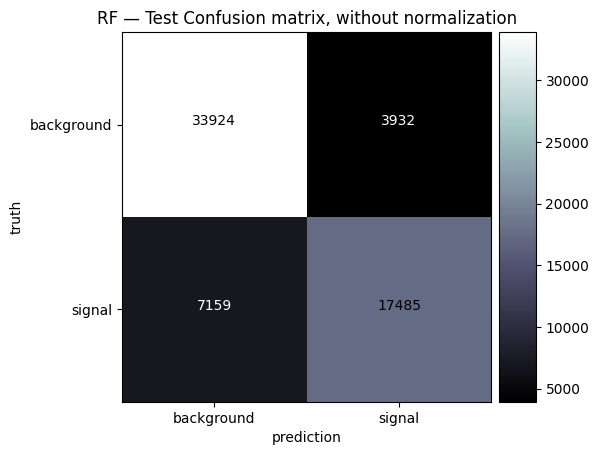

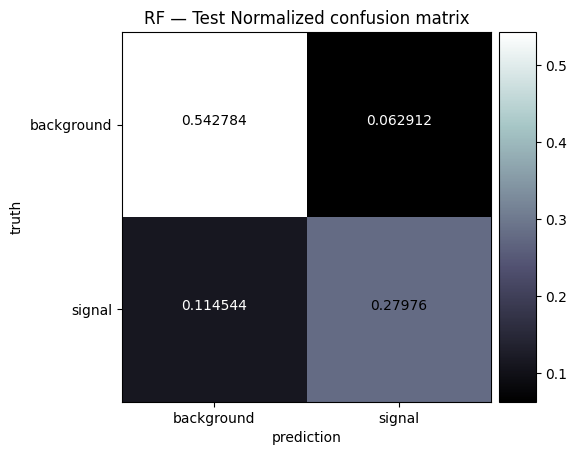

In [32]:

rf_pred_test  = rf.predict(test_x)

plot_confusion_matrix(test_y,  rf_pred_test,  normalize=False,
                      title='RF — Test',  labels=['signal','background'])
plot_confusion_matrix(test_y,  rf_pred_test,  normalize=True,
                      title='RF — Test',  labels=['signal','background'])

figure 1: The confusion matrix for RF model. The upper plot is the confusion matrix without normalization, and the bottom one is the one with normalization. From the plot, we coud see there are many signal been detected as backgroud.The model works good for regcognizing backrgound, but not good in detecting signal.

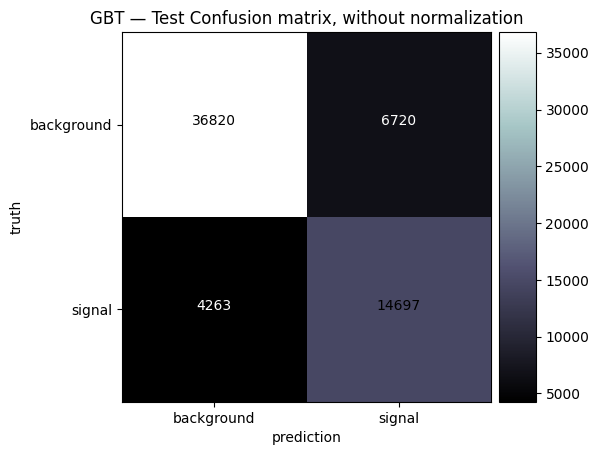

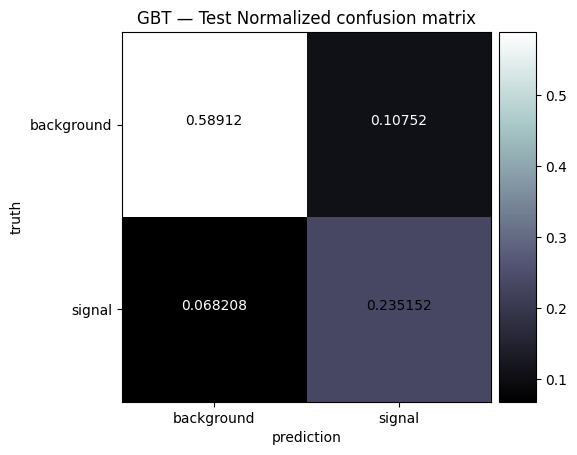

In [33]:
#do the same fo GBT, dont forget your captions!!
gbt_pred_test  = gbt.predict(test_x)
plot_confusion_matrix(test_y,  gbt_pred_test,  normalize=False,
                      title='GBT — Test',  labels=['signal','background'])
plot_confusion_matrix(test_y,  gbt_pred_test,  normalize=True,
                      title='GBT — Test',  labels=['signal','background'])

figure 2: The confusion matrix for gbt model. The upper plot is the confusion matrix without normalization, and the bottom one is the one with normalization. From the plot, we coud see there are many signal been detected as backgroud.However, compare with previous one, more signal is detected. On the other hand, more background is detected as signal.

Plot a simple ROC curve for the RF and GBT models  a d describe it in a caption.

In [34]:
#this will be passed to the ROC function
test_y.reshape(-1, 1).flatten() == "s"

array([False,  True, False, ..., False, False, False])

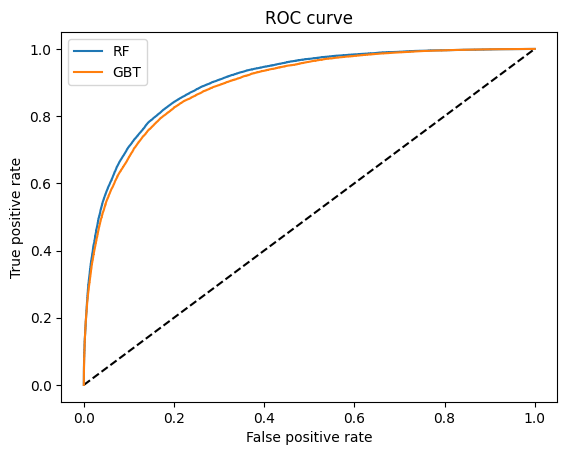

In [35]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


figure 3: The ROC curve of RT model and GBT mode. As we could see in this plot, RF shows more accuracy for most of part of the curve, which means in the same false positive rate, RF model could detect more ture signal.

#Task 7 required for 661, EC for 461, tree-based regression


- Use a Random Forest and a Gradiend Boosted Tree Regressor model to predict the weight of the particles. Compare the model performance on training and test sets


In [36]:
rfR = RandomForestRegressor(max_depth=3, random_state=302)
rfR.fit(train_regress_x, train_regress_y)
gbtR = GradientBoostingRegressor(max_depth=3, random_state=302)
gbtR.fit(train_regress_x, train_regress_y)

GradientBoostingRegressor(random_state=302)

 Calculate the L2 and L1 loss functions for the fitted regression models (see slides for the definition) and discuss the results

In [37]:
def L1(y1, y2):
  return np.sum(abs(y1 - y2))

def L2(y1, y2):
  return np.sum((y1-y2)**2)

In [38]:
print(f"L1 RF {L1(test_regress_y,  rfR.predict(test_regress_x)):.2f}, L2 RF {L2(test_regress_y, rfR.predict(test_regress_x)):.2f}")

L1 RF 62903.62, L2 RF 114449.75


In [39]:
print(f"L1 GBT {L1(test_regress_y,  gbtR.predict(test_regress_x)):.2f}, L2 GBT {L2(test_regress_y, gbtR.predict(test_regress_x)):.2f}")

L1 GBT 52711.61, L2 GBT 84829.96


**Discuss!**
RF L1 and L2 is greater than GBT L1 and L2, which suggests gbt perdicts more accurately.

#Task 8: Choose between feature importance and grid optimization (due for both 461 and 661)







# Task 8a: feature importance
Use the "Titanic notebook" as a guide for the feature importance analysis  https://github.com/fedhere/DSPS_FBianco/blob/main/Labs/DSPS_2025_titanictree.ipynb

- For the Random Forest classifier, find the **4 most important features** based on the simple unoptimized model you created earlier on. Use the documentation to find out what they are. We have not talked abotu the physics of this problem at all but the Kaggle challenge description should provide enogh information for you to comment on this result is somewhat superficially.

You can use ```rf.feature_importance_``` on the trained model to extract the relative importance of each feature (a number from 0 to 1) and then choose the features that have the 4 highest numbers (the numpy function ```argsort()``` is helpful here!)

(your features may looks slightly different than mine)

In [40]:
higgsdata = higgsdata.drop(["EventId", "Label", "Weight"], axis=1)

In [41]:

best_features_index_rf = rf.feature_importances_
best_features_index_rf = np.argsort(-best_features_index_rf)


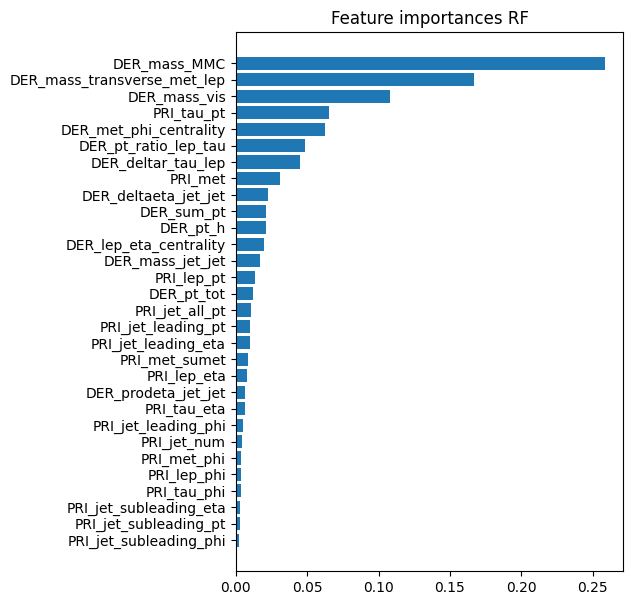

In [42]:
plt.figure(figsize=(5, 7))
plt.title("Feature importances RF")
indices_rf = best_features_index_rf

pl.barh(range(len(indices_rf), 0, -1),
        rf.feature_importances_[indices_rf], align="center")
# pl.xticks(range(rf.feature_importances_.shape[0]), indices)
pl.yticks(range(len(indices_rf), 0, -1),
          labels=higgsdata.columns[indices_rf])

pl.show()

figure 4: The importance of different features for RF model. As we can see, the DER mass MMC feature dominate the weight in RF model, which means while fitting, this feature plays an important role. The importance of feature decreasing shows exponetial trend.

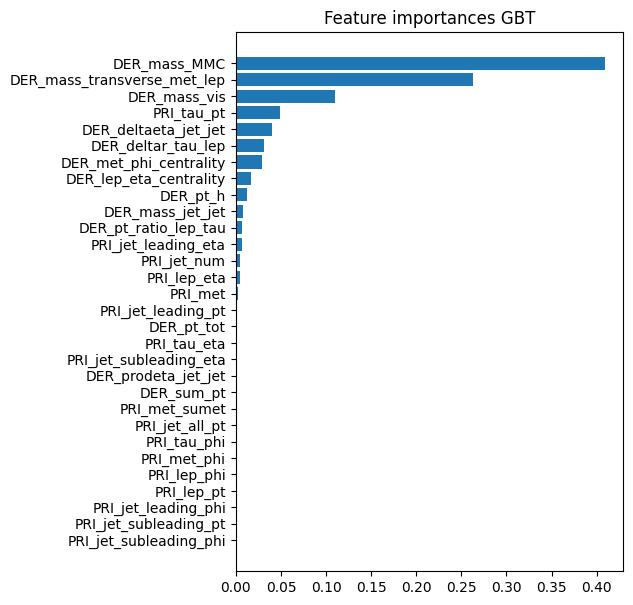

In [43]:
best_features_index_gbt = gbt.feature_importances_
best_features_index_gbt = np.argsort(-best_features_index_gbt)

plt.figure(figsize=(5, 7))
plt.title("Feature importances GBT")
indices_gbt = best_features_index_gbt

pl.barh(range(len(indices_gbt), 0, -1),
        gbt.feature_importances_[indices_gbt], align="center")
pl.yticks(range(len(indices_gbt), 0, -1),
          labels=higgsdata.columns[indices_gbt])

pl.show()

figure 5:The importance of different features for gbt model. DER mass MMC is still dominate the fitting. The trend is very same as RF, but the feature in the bottom part get less weight then RF model.

# Task 8b: hyperparameters grid search
- Explore the parameter space with the sklearn module ```sklearn.model_selection.RandomizedSearchCV``` *fitting only those 4 features*

Follow this example to set up the parameter search. Set the estimators to 10 and 100, (the number of trees) and the max depth to 3, and 10, and None (let it be unconstrained). Set bootstrap to both True and False. Set the number of features to consider at every split to both "autp" and "sqrt". Use ```pprint``` like I did earlier in this notebook to print the parameters set

**this takes some computational time! so do not start this at the last minute!!**

In [44]:
random_grid = {
    'n_estimators': [10, 100],
    'max_depth': [3, 10, None],
    'bootstrap': [True, False],
    'max_features': ['sqrt', None], # auto no longer seems to be an option
    'random_state': [1]
    }

In [45]:
pprint(random_grid)


{'bootstrap': [True, False],
 'max_depth': [3, 10, None],
 'max_features': ['sqrt', None],
 'n_estimators': [10, 100],
 'random_state': [1]}


 mine and your best features do not necessarily have to be the same because our models may be different (different parameters, different random seed etc)

In [46]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# Random search of parameters, using 3 fold cross validation,
# search across 18 different combinations
random_search = RandomizedSearchCV(estimator = rf, param_distributions=random_grid,
                                   n_iter=18, cv=3, verbose =4, random_state=1)


Note that this may take a long time! It took 1 hour for me to run this. Dont start at the last minute!!

In [47]:
new_x_train = train_x[higgsdata.columns[indices_rf][:4]]
new_x_test = test_x[higgsdata.columns[indices_rf][:4]]
random_search.fit(new_x_train[::5], train_y[::5])
# subselecting every 5th observation to reduce the computational time

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.787 total time=   2.5s
[CV 2/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.776 total time=   3.8s
[CV 3/3] END bootstrap=False, max_depth=3, max_features=sqrt, n_estimators=100, random_state=1;, score=0.776 total time=   3.0s
[CV 1/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.777 total time=   1.4s
[CV 2/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.767 total time=   1.4s
[CV 3/3] END bootstrap=False, max_depth=10, max_features=None, n_estimators=10, random_state=1;, score=0.764 total time=   1.4s
[CV 1/3] END bootstrap=True, max_depth=3, max_features=None, n_estimators=100, random_state=1;, score=0.784 total time=   3.5s
[CV 2/3] END bootstrap=True, max_depth=3, ma

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    max_depth=12,
                                                    min_samples_leaf=4,
                                                    min_samples_split=8,
                                                    n_jobs=-1,
                                                    random_state=1113),
                   n_iter=18,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 10, None],
                                        'max_features': ['sqrt', None],
                                        'n_estimators': [10, 100],
                                        'random_state': [1]},
                   random_state=1, verbose=4)

In [48]:
random_search.best_estimator_

RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       max_features=None, min_samples_leaf=4,
                       min_samples_split=8, n_jobs=-1, random_state=1)

In [49]:
for k in random_search.best_params_:
  print(k,random_search.best_params_[k])

random_state 1
n_estimators 100
max_features None
max_depth 10
bootstrap True


In [50]:
# set best params for new classifier
rf = RandomForestClassifier(**random_search.best_params_)
print(rf.get_params())

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 1, 'verbose': 0, 'warm_start': False}


In [51]:
rf.fit(train_x, train_y)

RandomForestClassifier(max_depth=10, max_features=None, random_state=1)

In [52]:
print("Tuned RF  Parameters: {}".format(random_search.best_params_))
print("Best score is {}".format(rf.score(test_x, test_y)))


Tuned RF  Parameters: {'random_state': 1, 'n_estimators': 100, 'max_features': None, 'max_depth': 10, 'bootstrap': True}
Best score is 0.831792


In [53]:
df = pd.DataFrame(random_search.cv_results_) # this shows the result for the given parameters
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_random_state,param_n_estimators,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,3.018611,0.526658,0.083248,0.016793,1,100,sqrt,3,False,"{'random_state': 1, 'n_estimators': 100, 'max_...",0.78728,0.77592,0.77600,0.779733,0.005336,9
1,1.361365,0.014467,0.032015,0.001994,1,10,None,10,False,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.77664,0.76720,0.76400,0.769280,0.005366,17
2,3.969574,0.891003,0.065225,0.004619,1,100,None,3,True,"{'random_state': 1, 'n_estimators': 100, 'max_...",0.78408,0.76912,0.76992,0.774373,0.006871,13
3,0.534423,0.018583,0.029929,0.000169,1,10,None,3,False,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.78456,0.77096,0.77120,0.775573,0.006355,11
4,1.075416,0.016354,0.041812,0.000242,1,10,sqrt,None,False,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.79128,0.78704,0.78864,0.788987,0.001748,8
5,7.985949,0.938748,0.128353,0.007200,1,100,sqrt,10,False,"{'random_state': 1, 'n_estimators': 100, 'max_...",0.79864,0.79016,0.79504,0.794613,0.003475,3
6,1.193924,0.012793,0.041334,0.000861,1,10,None,None,True,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.79496,0.79200,0.78712,0.791360,0.003233,6
7,0.542905,0.020045,0.031509,0.001722,1,10,sqrt,10,True,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.79280,0.79240,0.79528,0.793493,0.001274,4
8,0.418427,0.030636,0.033921,0.005418,1,10,None,3,True,"{'random_state': 1, 'n_estimators': 10, 'max_f...",0.78208,0.76824,0.77016,0.773493,0.006122,15
9,14.638242,0.072178,0.194797,0.008126,1,100,None,10,False,"{'random_state': 1, 'n_estimators': 100, 'max_...",0.77664,0.76712,0.76448,0.769413,0.005222,16


Plot a simple  ROC curve for the RF model with the best parameters found in the previous step. Describe it. Compare it with the GBT model from before

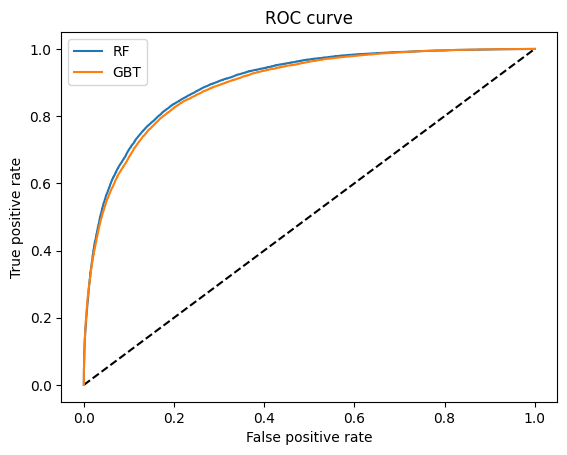

In [54]:
# The random forest model by itself
y_pred_grd_rfcat = rf.predict_proba(test_x)[:, 1]
y_pred_grd_gbtcat = gbt.predict_proba(test_x)[:, 1]

fpr_rf, tpr_rf, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_rfcat)
fpr_gbt, tpr_gbt, _ = roc_curve(test_y.reshape(-1, 1).flatten()=="s", y_pred_grd_gbtcat)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gbt, tpr_gbt, label='GBT')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

figure 6: The ROC curve of RT model and GBT mode. Very simillar as previous one ROC plot, RF shows more accuracy for most of part of the curve, which means in the same false positive rate, RF model could detect more ture signal